# Home Credit Default Risk

# Library used

In [149]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

# Machine Learning Library
from sklearn.metrics import multilabel_confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Decision Tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# XGBoost
import xgboost as xgb

from warnings import filterwarnings
filterwarnings('ignore')

## Data

In [150]:
app_train = pd.read_csv("./resources/application_train.csv", encoding='utf-8', sep=',')
app_test = pd.read_csv("./resources/application_test.csv", encoding='utf-8', sep=',')
app_train.drop_duplicates()
app_test.drop_duplicates()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


## Aligning the two datasets

In [151]:
train_labels = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# Data Analysis

In [152]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to TARGET
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


## Is data unbalanced ? 

<AxesSubplot:xlabel='TARGET', ylabel='count'>

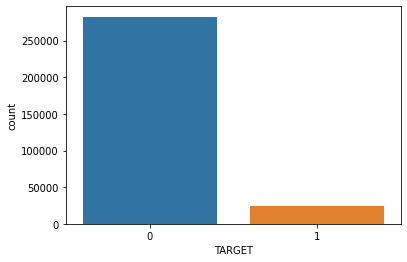

In [153]:
sns.countplot(x="TARGET", data=app_train)

The data is very unbalanced.

## Missing values

In [154]:
(app_train.isnull().sum()/app_train.shape[0])*100

SK_ID_CURR                     0.000000
NAME_CONTRACT_TYPE             0.000000
CODE_GENDER                    0.000000
FLAG_OWN_CAR                   0.000000
FLAG_OWN_REALTY                0.000000
                                ...    
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
TARGET                         0.000000
Length: 122, dtype: float64

In [155]:
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)
app_train.dropna(inplace= True)

app_test.replace([np.inf, -np.inf], np.nan, inplace=True)
app_test.dropna(inplace= True)

In [156]:
(app_train.isnull().sum()/app_train.shape[0])*100

SK_ID_CURR                    0.0
NAME_CONTRACT_TYPE            0.0
CODE_GENDER                   0.0
FLAG_OWN_CAR                  0.0
FLAG_OWN_REALTY               0.0
                             ... 
AMT_REQ_CREDIT_BUREAU_WEEK    0.0
AMT_REQ_CREDIT_BUREAU_MON     0.0
AMT_REQ_CREDIT_BUREAU_QRT     0.0
AMT_REQ_CREDIT_BUREAU_YEAR    0.0
TARGET                        0.0
Length: 122, dtype: float64

## Correlations

In [157]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n\n', correlations.tail(15))
print('\nMost Negative Correlations:\n\n', correlations.head(15))

Most Positive Correlations:

 DEF_30_CNT_SOCIAL_CIRCLE       0.022807
DAYS_ID_PUBLISH                0.024877
OWN_CAR_AGE                    0.028052
OBS_60_CNT_SOCIAL_CIRCLE       0.030730
OBS_30_CNT_SOCIAL_CIRCLE       0.031041
AMT_REQ_CREDIT_BUREAU_YEAR     0.033832
DAYS_BIRTH                     0.041108
REGION_RATING_CLIENT           0.053614
FLAG_DOCUMENT_3                0.054269
REGION_RATING_CLIENT_W_CITY    0.061214
DAYS_EMPLOYED                  0.062950
TARGET                         1.000000
FLAG_MOBIL                          NaN
FLAG_DOCUMENT_2                     NaN
FLAG_DOCUMENT_4                     NaN
Name: TARGET, dtype: float64

Most Negative Correlations:

 EXT_SOURCE_3           -0.150720
EXT_SOURCE_2           -0.130969
EXT_SOURCE_1           -0.129548
FLOORSMAX_AVG          -0.046110
FLOORSMAX_MODE         -0.045990
FLOORSMAX_MEDI         -0.045206
AMT_INCOME_TOTAL       -0.039762
FLOORSMIN_MEDI         -0.033313
FLOORSMIN_AVG          -0.032904
FLOORSMIN_MOD

# Data cleanup 

In [170]:
mini = abs(app_train['DAYS_EMPLOYED'].max())
if mini > 365:
    print("Days employed min :", mini/365, "days" )
else:
    print("Days employed min :", mini, "days" )


Days employed min : 4 days


In [171]:
maxi = abs(app_train['DAYS_EMPLOYED'].min())
print("Days employed max :", maxi/365, "years" )

Days employed max : 39.38356164383562 years


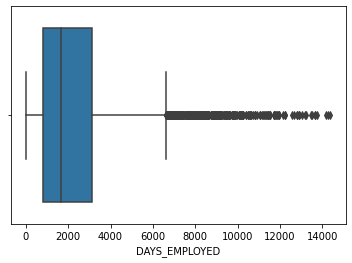

In [176]:
ax = sns.boxplot(x=abs(app_train['DAYS_EMPLOYED']))

# Making our model

## Label encoding certain columns

In [158]:
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        le.fit(app_train[col])
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        le_count += 1
        print(col)
app_train.reset_index()
app_test.reset_index()
print('%d columns were label encoded.' % le_count)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
OCCUPATION_TYPE
WEEKDAY_APPR_PROCESS_START


ValueError: y contains previously unseen labels: 'Trade: type 5'

# Splitting data into train and validation

In [ ]:
Xdf = app_train
Xdf.drop("TARGET", axis = 1)
X = np.array(Xdf)

y = np.array(app_train["TARGET"])

In [ ]:
# Recommended test sizes for crossvalidation : [20, 25, 30]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y)

# Logistic regression

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)